In [1]:
import numpy as np
import pandas as pd
from utils import equilibrium
import matplotlib.pyplot as plt
%matplotlib inline

# Data Input

### Species

In [2]:
species = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.0.1 Pokémon Dex Data', header=1, nrows=453, index_col='Shorthand' 
                       , skiprows=[163], usecols=[4, 9, 16, 17, 19, 20, 21], names=['Final', 'Type1','Type2','Atk','Def','Sta'])
species = species.rename(index={'Shorthand': 'Name'})
species = species.fillna('Empty')
species.Atk += 15
species.Def += 15
species.Sta += 15

### Pokemon Moves

In [3]:
species_moves = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.1.1 Pokémon GO Moves', header=1, nrows=392
                             , skiprows=[133], usecols=[1, 2, 3, 4, 5, 6])

### Moves

In [4]:
moves = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.1.2 Attack Dex (GO)', header=0, usecols=[0, 1, 2, 4, 5, 7]
                     , index_col='Move', names=['Type', 'Fast', 'Power', 'Energy', 'Duration'])
moves.Duration /= 1000

### Type effectiveness

In [5]:
effi = pd.read_excel('UW PokéDex GO.xlsx', sheet_name='0.3.1 Type Table', header=0
                     , usecols=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]).T
effi **= np.log(1.6) / np.log(1.4)

# Data Transform

In [6]:
pokemon = pd.read_csv("stats.csv", sep='\t', nrows=0)

for i in range(len(species_moves)):
    if species.loc[species_moves.Pokémon[i], "Final"]:
        for j in range(1, 3):
            if pd.notna(species_moves.iloc[i, j]):
                for k in range(3, 6):
                    if pd.notna(species_moves.iloc[i, k]):
                        pokemon = pokemon.append(species.loc[species_moves.Pokémon[i]])
                        pokemon.ix[-1, 'Name'] = pokemon.index[-1]
                        pokemon.ix[-1, 'Fast'] = species_moves.iloc[i, j]
                        pokemon.ix[-1, 'Charge'] = species_moves.iloc[i, k]
                        pokemon.ix[-1, 'Type_F'] = moves.loc[pokemon.iloc[-1].Fast].Type
                        pokemon.ix[-1, 'Type_C'] = moves.loc[pokemon.iloc[-1].Charge].Type
                        pokemon.ix[-1, 'Power1'] = moves.loc[pokemon.iloc[-1].Fast].Power
                        pokemon.ix[-1, 'Energy1'] = moves.loc[pokemon.iloc[-1].Fast].Energy
                        pokemon.ix[-1, 'Time1'] = moves.loc[pokemon.iloc[-1].Fast].Duration
                        pokemon.ix[-1, 'Stab1'] = 1.2 if pokemon.iloc[-1].Type_F in (pokemon.iloc[-1].Type1, pokemon.iloc[-1].Type2) else 1
                        pokemon.ix[-1, 'Power2'] = moves.loc[pokemon.iloc[-1].Charge].Power
                        pokemon.ix[-1, 'Energy2'] = moves.loc[pokemon.iloc[-1].Charge].Energy
                        pokemon.ix[-1, 'Time2'] = moves.loc[pokemon.iloc[-1].Charge].Duration
                        pokemon.ix[-1, 'Stab2'] = 1.2 if pokemon.iloc[-1].Type_C in (pokemon.iloc[-1].Type1, pokemon.iloc[-1].Type2) else 1

n = len(pokemon)                    

/home/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/home/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-inde

# Payoff matrix

In [7]:
n = len(pokemon)                    
payoff = np.zeros((n, n))

### Computation

In [8]:
for i in range(n):
    for j in range(n):
        attacker, defender = pokemon.iloc[i], pokemon.iloc[j]
        attacker_power = attacker.Atk * attacker.Def * attacker.Sta
        defender_power = defender.Atk * defender.Def * defender.Sta * 2

        fast_damage = attacker.Power1 * attacker.Stab1 * effi.loc[attacker.Type_F, defender.Type1] * effi.loc[attacker.Type_F, defender.Type2]
        charge_damage= attacker.Power2 * attacker.Stab2 * effi.loc[attacker.Type_C, defender.Type1] * effi.loc[attacker.Type_C, defender.Type2]
        weight = attacker.Energy1 / attacker.Energy2
        attacker_dps = (fast_damage + weight * charge_damage) / (attacker.Time1 + weight * attacker.Time2)
        attacker_dps = max(attacker_dps, fast_damage / attacker.Time1)
                
        fast_damage = defender.Power1 * defender.Stab1 * effi.loc[defender.Type_F, attacker.Type1] * effi.loc[defender.Type_F, attacker.Type2]
        charge_damage= defender.Power2 * defender.Stab2 * effi.loc[defender.Type_C, attacker.Type1] * effi.loc[defender.Type_C, attacker.Type2]
        weight = defender.Energy1 / defender.Energy2
        defender_dps = (fast_damage + weight * charge_damage) / (defender.Time1 + 2 + weight * (defender.Time2 + 2))
        
        payoff[i, j] = np.log(attacker_power * attacker_dps / defender_power / defender_dps)

### Visualization

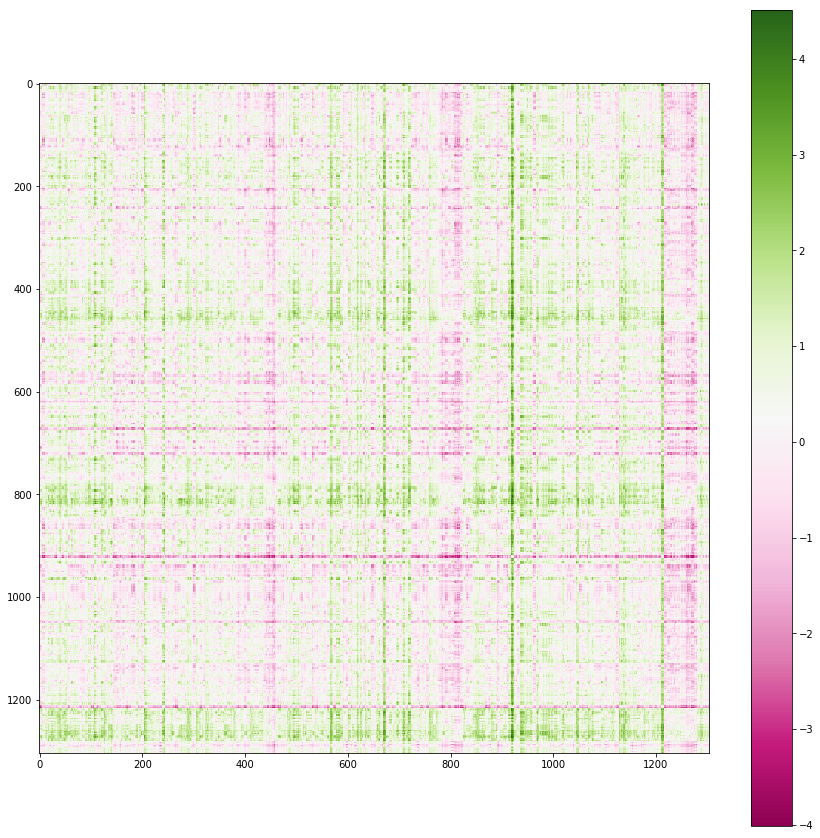

In [9]:
plt.figure(figsize=(15, 15))
plt.imshow(payoff, cmap='PiYG')
plt.colorbar()

# Equilibrium

### Calculate the equlibrium

In [10]:
p, q = equilibrium(payoff, 10000)
p[abs(p)<0.01] = 0
q[abs(q)<0.01] = 0

### Attacker list

In [11]:
dfp = pokemon.iloc[p.nonzero()].copy()
dfp['Weight'] = p[p.nonzero()]
dfp

,Name,Type1,Type2,Atk,Def,Sta,Fast,Type_F,Power1,Energy1,Time1,Stab1,Charge,Type_C,Power2,Energy2,Time2,Stab2,Final,Weight
Mewtwo,Mewtwo,Psychic,Empty,345,215,250,Psycho Cut,Psychic,5.0,8.0,0.6,1.2,Shadow Ball,Ghost,100.0,50.000000,3,1,1.0,0.366326
Tyranitar,Tyranitar,Rock,Dark,266,222,240,Bite,Dark,6.0,4.0,0.5,1.2,Crunch,Dark,70.0,33.333333,3.2,1.2,1.0,0.112793
Kyogre,Kyogre,Water,Empty,312,265,240,Waterfall,Water,16.0,8.0,1.2,1.2,Thunder,Electric,100.0,100.000000,2.4,1,1.0,0.169831
Kyogre,Kyogre,Water,Empty,312,265,240,Waterfall,Water,16.0,8.0,1.2,1.2,Blizzard,Ice,130.0,100.000000,3.1,1,1.0,0.191899
Groudon,Groudon,Ground,Empty,312,265,240,Dragon Tail,Dragon,15.0,9.0,1.1,1,Solar Beam,Grass,180.0,100.000000,4.9,1,1.0,0.045367
Rayquaza,Rayquaza,Dragon,Flying,327,202,248,Dragon Tail,Dragon,15.0,9.0,1.1,1.2,Outrage,Dragon,110.0,50.000000,3.9,1.2,1.0,0.106192


### Defender list

In [12]:
dfq = pokemon.iloc[q.nonzero()].copy()
dfq['Weight'] = q[q.nonzero()]
dfq

,Name,Type1,Type2,Atk,Def,Sta,Fast,Type_F,Power1,Energy1,Time1,Stab1,Charge,Type_C,Power2,Energy2,Time2,Stab2,Final,Weight
Mewtwo,Mewtwo,Psychic,Empty,345,215,250,Confusion,Psychic,20.0,15.0,1.6,1.2,Shadow Ball,Ghost,100.0,50.0,3,1,1.0,0.463712
Raikou,Raikou,Electric,Empty,256,210,222,Volt Switch,Electric,20.0,25.0,2.3,1.2,Wild Charge,Electric,90.0,50.0,2.6,1.2,1.0,0.027917
Kyogre,Kyogre,Water,Empty,312,265,240,Waterfall,Water,16.0,8.0,1.2,1.2,Hydro Pump,Water,130.0,100.0,3.3,1.2,1.0,0.101489
Kyogre,Kyogre,Water,Empty,312,265,240,Waterfall,Water,16.0,8.0,1.2,1.2,Thunder,Electric,100.0,100.0,2.4,1,1.0,0.107640
Kyogre,Kyogre,Water,Empty,312,265,240,Waterfall,Water,16.0,8.0,1.2,1.2,Blizzard,Ice,130.0,100.0,3.1,1,1.0,0.105802
Groudon,Groudon,Ground,Empty,312,265,240,Dragon Tail,Dragon,15.0,9.0,1.1,1,Solar Beam,Grass,180.0,100.0,4.9,1,1.0,0.106194
Rayquaza,Rayquaza,Dragon,Flying,327,202,248,Dragon Tail,Dragon,15.0,9.0,1.1,1.2,Outrage,Dragon,110.0,50.0,3.9,1.2,1.0,0.087183


### File output

In [13]:
with open('metalist.csv', 'w') as f:
    f.write('--------Attack List---------\n')
    f.write(dfp.to_csv())
    f.write('--------Defend List---------\n')
    f.write(dfq.to_csv())